In [1]:
import sys
import shutil
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import *
from plot_skylocs import LimitPlot
from astropy.cosmology import Planck15
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
catalog = pd.read_csv("/tigress/nrodd/DM-Catalog-Scan/DataFiles/Catalogs/2MRSLocalTully_ALL_DATAPAPER_Planck15_v7.csv")

/tigress/smsharma/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
plot_data = LimitPlot(data_dir='/tigress/nrodd/DM-Catalog-Scan/Scan-Small-ROI/data/Tully//',
                        elephant=False, 
                        nmc=1,
                        bcut=20,
                        nonoverlap=True,
                        nonoverlapradius=2.,
                        cut_0p5=False,
                        xsecslim=10,
                        TS100=4,
                        TS1000=9,
                        halos_ran=1000, 
                        halos_to_keep=1000,
                        data_type="data",
                        catalog_file="/tigress/nrodd/DM-Catalog-Scan/DataFiles/Catalogs/2MRSLocalTully_ALL_DATAPAPER_Planck15_v7.csv")

plot_data_skylocs = LimitPlot(data_dir='/tigress/nrodd/DM-Catalog-Scan/Scan-Small-ROI/data/Tully_skylocs_no0p5mask',
                        elephant=False, 
                        nmc=200,
                        bcut=20,
                        nonoverlap=True,
                        nonoverlapradius=2.,
                        xsecslim=10,
                        TS100=4,
                        TS1000=9,
                        halos_ran=1000, 
                        halos_to_keep=1000,
                        data_type="skylocs")

/tigress/smsharma/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
data_ary, _, maxTS_ary = plot_data.return_limits()

In [5]:
en_bins = 2*np.logspace(-1,3,41)
bin_centers = [10**((np.log10(en_bins[i])+np.log10(en_bins[i+1]))/2.) for i in range(40)]

en_stacked = np.vstack((en_bins,en_bins)).reshape((-1,),order='F')[1:-1]

In [ ]:
fig, axes2d = plt.subplots(nrows=5, ncols=2,
                           figsize=(15,20))

data_dir = "../data/Tully/"
sim_dir = "../data/Tully_randlocs"
for l, row in tqdm_notebook(enumerate(axes2d)):
    for j, cell in enumerate(row):
        ihalo = l*2 + j
        halo = plot_data.passed_halos[l*2 + j]
        d_ivals = np.load(data_dir + 'LL_inten_o'+str(halo)+'_data.npz')['intens']
        d_lvals = np.load(data_dir + 'LL_inten_o'+str(halo)+'_data.npz')['LL']
        
        rep_angext = np.array([0.02785567,0.12069876,0.21354185,0.30638494,0.39922802,0.49207111,0.5849142,0.67775728,0.77060037,0.86344346,0.95628654,1.04912963,1.14197272,1.2348158,1.32765889,1.42050198,1.51334507,1.60618815,1.69903124,1.79187433])
        obj_angext = 2*catalog[u'rs'].values[ihalo] / \
                     (Planck15.angular_diameter_distance(catalog[u'z'].values[ihalo]).value*1000) \
                     * 180./np.pi
        rep_index = (np.abs(rep_angext-obj_angext)).argmin()
        print "At halo:",ihalo
        print "Rep index:",rep_index
        
        s_ivals = np.load(sim_dir + '0/LL_inten_o'+str(rep_index)+'_data.npz')['intens'] # intensity the same for all MC

        nsim = 1500
        sim_arr_all = np.zeros(shape=(nsim,40,200))

        limit_total = np.zeros((nsim, 40 ))

        for i in (range(nsim)):
            sim_arr_all[i] = np.load(sim_dir + str(i) + '/LL_inten_o'+str(rep_index)+'_data.npz')['LL']

        for i in (range(40)):
            tmp_TS = np.zeros(shape=(nsim,200))
            for j in range(nsim):
                tmp_TS[j] = 2*(sim_arr_all[j,i,:]-sim_arr_all[j,i,0])
                max_arg= np.argmax(tmp_TS[j])
                max_val = tmp_TS[j][max_arg]
                for xi in range(max_arg,len(s_ivals[i])):
                    val = tmp_TS[j][xi]-max_val
                    if val < -2.71:
                        limit_total[j, i] = s_ivals[i][xi]
                        break



        limit_data = np.zeros(40)
        for en in range(40):
            TS_data = 2*(d_lvals[en]-d_lvals[en,0])
            max_arg= np.argmax(TS_data)
            max_val = TS_data[max_arg]
            for xi in range(max_arg,len(d_ivals[en])):
                val = TS_data[xi]-max_val
                if val < -2.71:
                    limit_data[en] = d_ivals[en][xi]
                    break

        lims = np.transpose([corner.quantile(np.transpose(limit_total)[i],[.025,0.14,.68,0.975]) for i in range(40)])

        fluxlim_stacked = np.vstack((limit_data,limit_data)).reshape((-1,),order='F')[:]
        fluxlim_stacked_sim2p5 = np.vstack((lims[0],lims[0])).reshape((-1,),order='F')[:]
        fluxlim_stacked_sim16 = np.vstack((lims[1],lims[1])).reshape((-1,),order='F')[:]
        fluxlim_stacked_sim68 = np.vstack((lims[2],lims[2])).reshape((-1,),order='F')[:]
        fluxlim_stacked_sim97p5 = np.vstack((lims[3],lims[3])).reshape((-1,),order='F')[:]

        cell.fill_between(np.log10(en_stacked), np.log10(fluxlim_stacked_sim2p5),np.log10(fluxlim_stacked_sim97p5), color='yellow',alpha=0.6)
        cell.fill_between(np.log10(en_stacked), np.log10(fluxlim_stacked_sim16),np.log10(fluxlim_stacked_sim68), color='limegreen',alpha=0.7)
        
        cell.set_xlabel("$E$ [GeV]")
        
        if ihalo == 4:
            cell.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")


        cell.set_xlim(np.log10(.2),np.log10(2000))
        cell.set_ylim(-12,-8)
        
        cell.set_yticks([-12,-10,-8])
        cell.set_yticklabels(["$10^{-12}$","$10^{-10}$","$10^{-8}$"], fontsize=23)
    

        cell.set_xticks([0,1,2,3])
        cell.set_xticklabels(["$10^{0}$","$10^{1}$","$10^{2}$","$10^{3}$"], fontsize=23)


        for i in range(len(bin_centers)):
            cell.arrow(np.log10(bin_centers[i]), np.log10(limit_data[i]), 0, -.3, length_includes_head=True,head_width=.06, head_length=.1, fc='k', ec='k')

        cell.errorbar(np.log10(bin_centers), np.log10(limit_data), marker='_',markersize= 6.,color='k',ls='none')

        cell.text(3.,-8.8, r'\textbf{Object '+str(halo)+'} / ' + catalog['Name'].values[halo].replace("_", ""), fontsize=17, color='k',horizontalalignment='right')

plt.tight_layout()
#plt.savefig(plots_dir + "FluxUL.pdf")

At halo: 1
Rep index: 19
At halo: 3
Rep index: 19
At halo: 6
Rep index: 19
At halo: 7
Rep index: 16
At halo: 8
Rep index: 15
At halo: 10
Rep index: 16
At halo: 12
Rep index: 13
At halo: 14
Rep index: 10
At halo: 20
Rep index: 9
At halo: 21
Rep index: 9



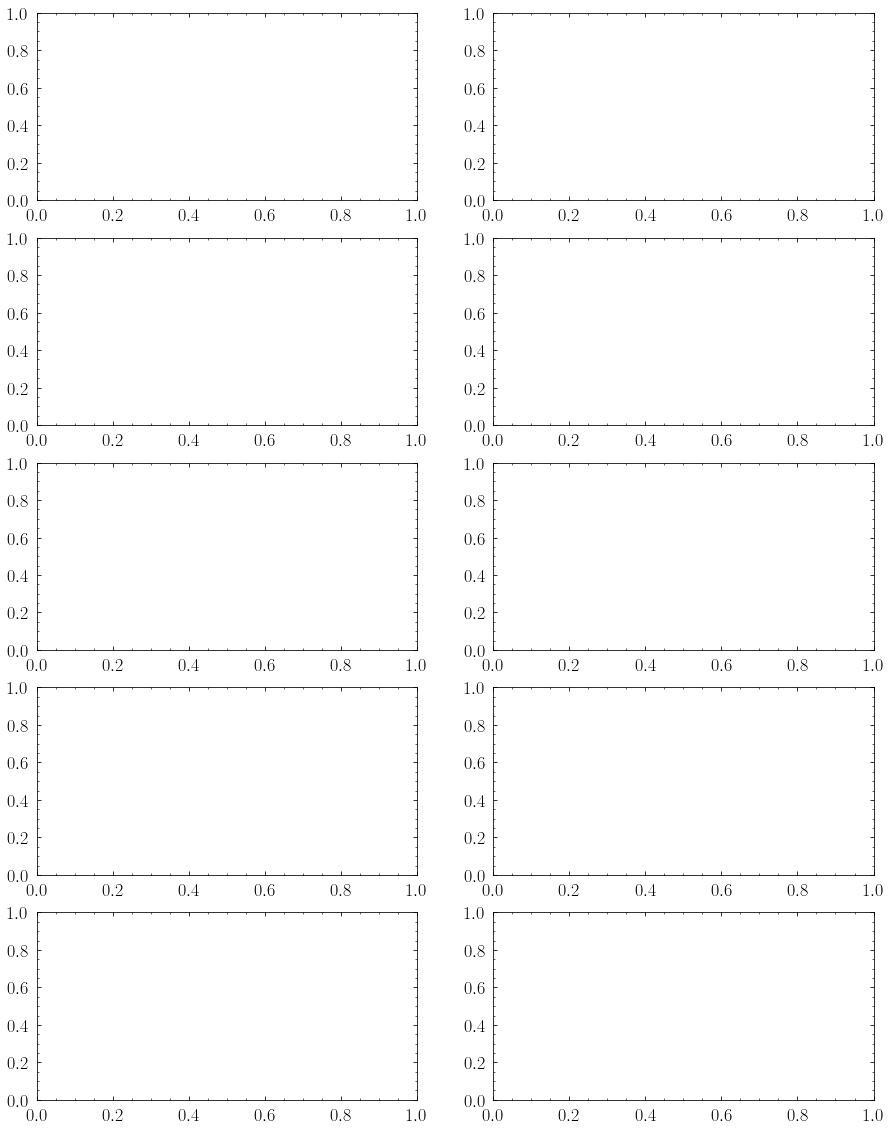

In [6]:
fig, axes2d = plt.subplots(nrows=5, ncols=2,
                           figsize=(15,20))

data_dir = "../data/Tully/"
sim_dir = "../data/Tully_randlocs"
for l, row in tqdm_notebook(enumerate(axes2d)):
    for j, cell in enumerate(row):
        ihalo = l*2 + j
        halo = plot_data.passed_halos[l*2 + j]
        d_ivals = np.load(data_dir + 'LL_inten_o'+str(halo)+'_data.npz')['intens']
        d_lvals = np.load(data_dir + 'LL_inten_o'+str(halo)+'_data.npz')['LL']
        
        rep_angext = np.array([0.02785567,0.12069876,0.21354185,0.30638494,0.39922802,0.49207111,0.5849142,0.67775728,0.77060037,0.86344346,0.95628654,1.04912963,1.14197272,1.2348158,1.32765889,1.42050198,1.51334507,1.60618815,1.69903124,1.79187433])
        obj_angext = 2*catalog[u'rs'].values[ihalo] / \
                     (Planck15.angular_diameter_distance(catalog[u'z'].values[ihalo]).value*1000) \
                     * 180./np.pi
        rep_index = (np.abs(rep_angext-obj_angext)).argmin()
        print "At halo:",halo
        print "Rep index:",rep_index